In [1]:
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.optim as optim
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Grayscale, Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, ToPILImage
from sklearn.model_selection import train_test_split

In [2]:
BATCH_SIZE = 256
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

set_seed(42)

Random seed set as 42


# Подготовка данных #

In [4]:
df = pd.read_csv('cybersequrity.csv')
df

,svcscan.fs_drivers,callbacks.ngeneric,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_eprocess_pool,callbacks.nanonymous,psxview.not_in_session,psxview.not_in_pslist,psxview.not_in_pspcid_list,psxview.not_in_ethread_pool,psxview.not_in_csrss_handles,psxview.not_in_pslist_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_deskthrd,psxview.not_in_ethread_pool_false_avg,psxview.not_in_session_false_avg,Class
0,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.044444,1
1,26,8,0.0,0,0,5,3,3,3,7,0.073171,0.073171,9,0.073171,0.121951,1
2,26,8,0.0,0,0,9,7,7,7,11,0.152174,0.152174,13,0.152174,0.195652,1
3,26,8,0.0,0,0,3,1,1,2,6,0.022222,0.022222,9,0.044444,0.066667,1
4,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,6,0.000000,0.048780,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,26,8,0.0,0,0,4,2,2,2,6,0.048780,0.048780,8,0.048780,0.097561,1
9996,26,8,0.0,0,0,2,0,0,0,4,0.000000,0.000000,5,0.000000,0.062500,1
9997,26,8,0.0,0,1,2,0,0,0,4,0.000000,0.000000,5,0.000000,0.062500,1
9998,26,8,0.0,0,0,8,6,6,7,11,0.127629,0.127629,13,0.148511,0.169392,0


In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape

((6000, 15), (2000, 15), (2000, 15))

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

### Создадим объекты классов dataset и dataloader

In [9]:
class CustomDataset(Dataset):
    def __init__(self, X, labels):
        self.X = torch.Tensor(X.values)
        self.labels = torch.from_numpy(labels.values).reshape(-1, 1).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.labels[index])

In [10]:
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Реализация MLP #

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation_fn):
        super(MLP, self).__init__() 
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), activation_fn()])
            
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

# train-loop и eval-loop #

### Будем всегда использовать кросс энтропийный лосс, так как мне кажется, что это золотой стандарт.
### Но также добавим возможность менять наш лосс для будущих задач

### Также в процессе обучения будем динамически менять графики качества и лосса

In [13]:
def train_model(model, optimizer, loss_func=nn.BCELoss(), num_epochs=100, eval_freq=20):
    train_loss_hist, eval_loss_hist = [], []
    train_f1_hist, eval_f1_hist = [], []
    global_step = 0
    model.train()
    for epoch in tqdm(range(num_epochs)):
      for X, target in train_dataloader:
        optimizer.zero_grad()
        log_probs = model(X.to(device))
        loss = loss_func(log_probs, target.to(device))
        loss.backward()
        optimizer.step()
    
        preds = (log_probs >= 0.5).int().cpu().numpy()
        f1 = f1_score(preds, target.cpu().numpy())
    
        train_loss_hist.append((global_step, loss.item()))
        train_f1_hist.append((global_step, f1))
    
        if global_step % eval_freq == 0:
              val_loss, val_f1 = eval_mod(model, loader=val_dataloader)
              eval_loss_hist.append((global_step, val_loss))
              eval_f1_hist.append((global_step, val_f1))
    
              model.train()
    
        if global_step % 250 == 0:
              clear_output(True)
    
              plt.figure(figsize=(15, 5))
    
              plt.subplot(121)
              plt.plot(*zip(*train_loss_hist), alpha=0.5, label='train_loss')
              if len(eval_loss_hist):
                  plt.plot(*zip(*eval_loss_hist), color='red', label='eval_loss')
              plt.legend()
    
              plt.subplot(122)
              plt.plot(*zip(*train_f1_hist), alpha=0.5, label='train_f1')
              if len(eval_f1_hist):
                  plt.plot(*zip(*eval_f1_hist), color='red', label='eval_f1')
              plt.legend()
              plt.show()
        global_step += 1
    
    return model

In [14]:
def eval_mod(model, loader, loss_func=nn.BCELoss(), thr=0.5):
    model.eval()
    all_loss = 0
    all_logits = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, target in loader:
            x, target = x.to(device), target.to(device)
            outputs = model(x)
            loss = loss_func(outputs, target)
            all_loss += loss.item()
            
            predicted = (outputs > thr).float()
            all_logits.extend(outputs.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds)
    avg_loss = all_loss / len(loader)
    return avg_loss, f1

# обучение модели и проверка качества

In [15]:
def make_classification_report(model, loader, thr=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, labels in loader:
            x, labels = x.to(device), labels.to(device)
            outputs = model(x)
            predicted = (outputs > thr).float()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(classification_report(all_labels, all_preds))

### Зададим функцию активации, кол-во и размер каждого слоя

In [16]:
activation = nn.Sigmoid
hidden_sizes = [15, 15]

### Создадим нашу модельб зададим стандартный оптимизатор и натренируем модель

In [17]:
model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)

MLP(
  (layers): Sequential(
    (0): Linear(in_features=15, out_features=15, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=15, out_features=15, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=15, out_features=1, bias=True)
  )
)

In [18]:
optimizer = optim.SGD(model.parameters(), lr=0.01)

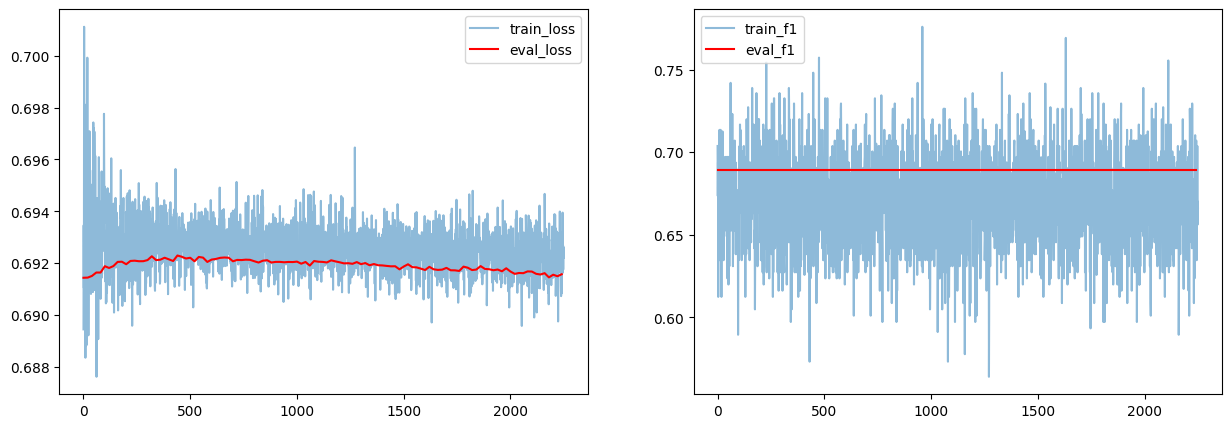

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.21it/s]


In [19]:
from tqdm import tqdm
model = train_model(model, optimizer=optimizer, num_epochs=100)

Видно, что функция потерь не сильно убывает при обучении, а f1_scorе не растет вовсе.
Скорее всего нужно еще поработать с различными параметрами модели, чтобы докрутить ее

In [20]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.6914679408073425
Значение f1-score на валидационной выборке:  0.6893840104849279
Значение лосса на тестовой выборке:  0.6920314878225327
Значение f1-score на тестовой выборке:  0.6719787516600265


In [21]:
make_classification_report(model, loader=test_dataloader)

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       988
         1.0       0.51      1.00      0.67      1012

    accuracy                           0.51      2000
   macro avg       0.25      0.50      0.34      2000
weighted avg       0.26      0.51      0.34      2000



C:\Users\lsd24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lsd24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\lsd24\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

# Улучшение модели и увеличение качества

Первым делом я поменял оптимизатор, на Adam, который вроде тоже считается золотым стандартом.
Также я уменьшил lr и увеличил кол-во эпох.

В результате  качество даже неиного снизилось, но лосс упал значительно

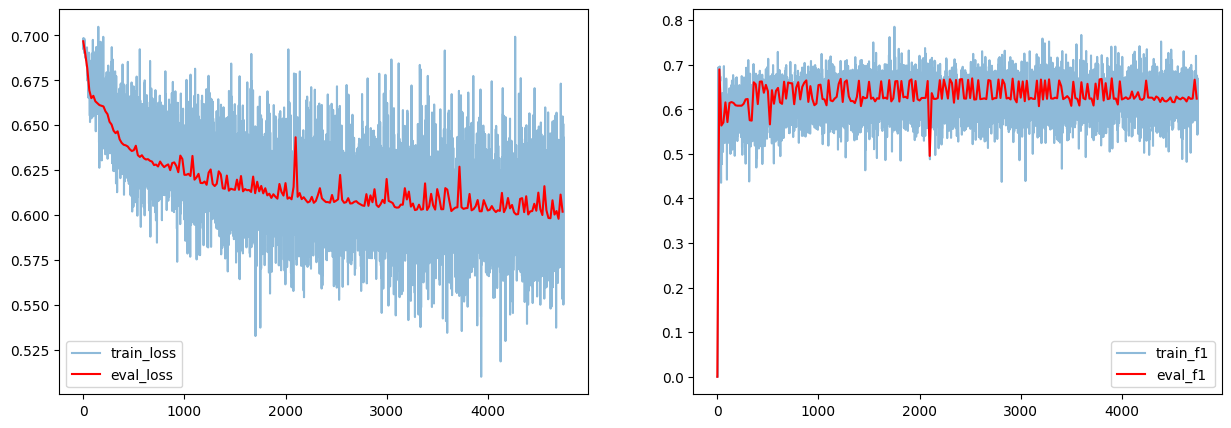

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:30<00:00,  6.53it/s]


In [22]:
activation = nn.Sigmoid
hidden_sizes = [15, 15]
model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [23]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.600510984659195
Значение f1-score на валидационной выборке:  0.6710327455919396
Значение лосса на тестовой выборке:  0.5992095395922661
Значение f1-score на тестовой выборке:  0.664218258132214


### попробуем добавить слои

Видим, что качество увеличилось, а лосс еще упал, значит мы на верном пути

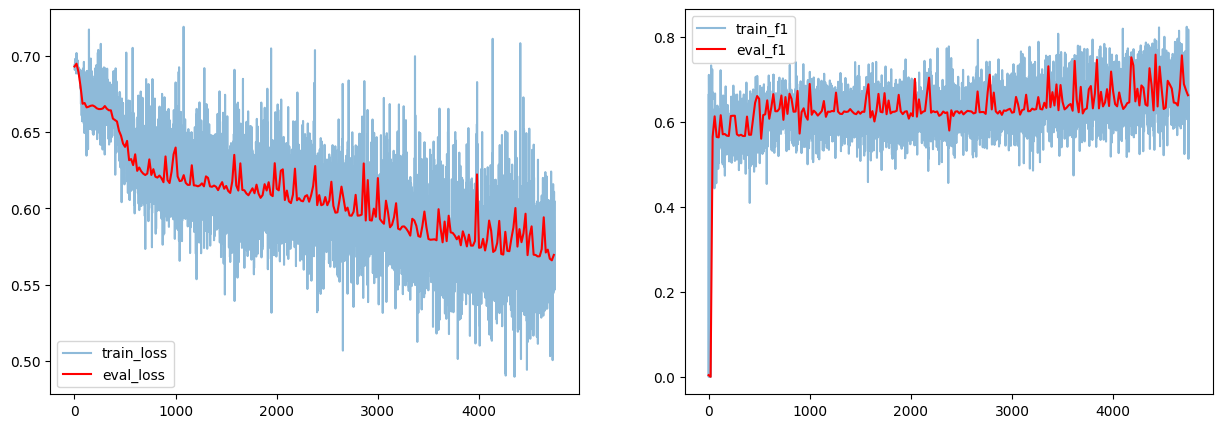

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.31it/s]


In [24]:
activation = nn.Sigmoid
hidden_sizes = [15, 15, 15]
model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [25]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.56756641715765
Значение f1-score на валидационной выборке:  0.7054187192118226
Значение лосса на тестовой выборке:  0.5638625547289848
Значение f1-score на тестовой выборке:  0.7072049054675523


### попробуем добавить еще слоев

Видим, что качество упало, остановимся на 4х слоях

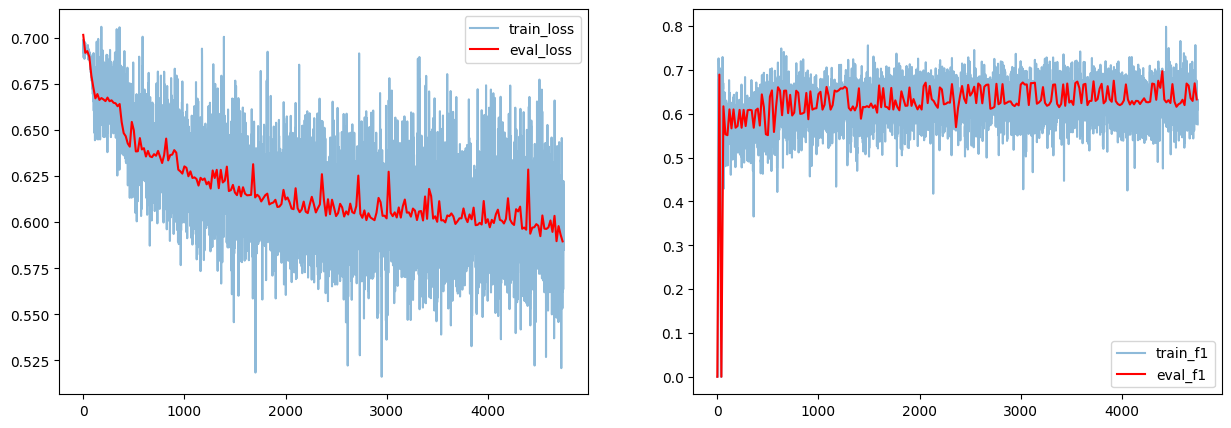

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.17it/s]


In [26]:
activation = nn.Sigmoid
hidden_sizes = [15, 15, 15, 15]
model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [27]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.6030933484435081
Значение f1-score на валидационной выборке:  0.6160046056419114
Значение лосса на тестовой выборке:  0.6001621559262276
Значение f1-score на тестовой выборке:  0.6175942549371634


### Поменяем размеры слоев

Как видим, качество  повысилось

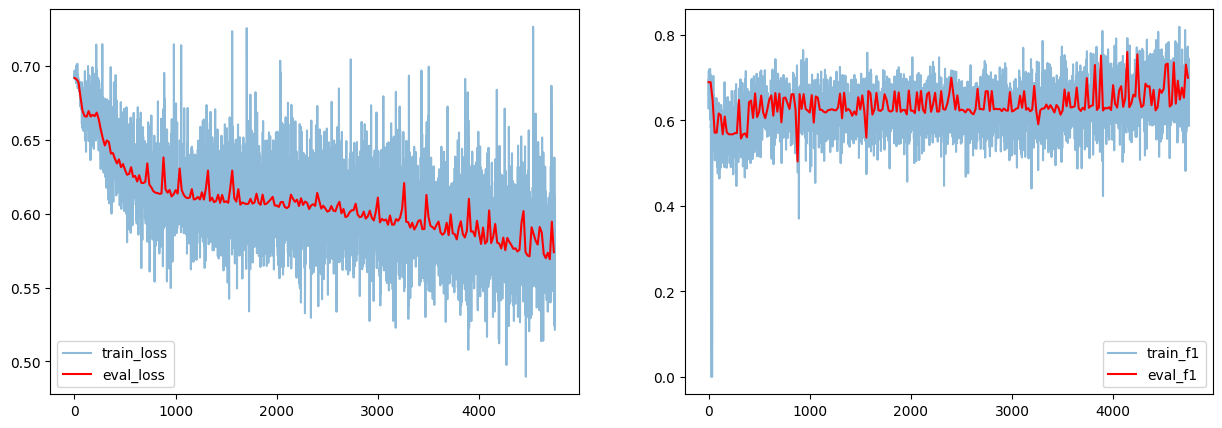

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.39it/s]


In [28]:
activation = nn.Sigmoid
hidden_sizes = [20, 15, 10]
model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [29]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.5711063891649246
Значение f1-score на валидационной выборке:  0.64385866517106
Значение лосса на тестовой выборке:  0.5638812035322189
Значение f1-score на тестовой выборке:  0.658493870402802


### Попробуем поменять функцию потерь

Ниже видно, что с relu результат немного упал

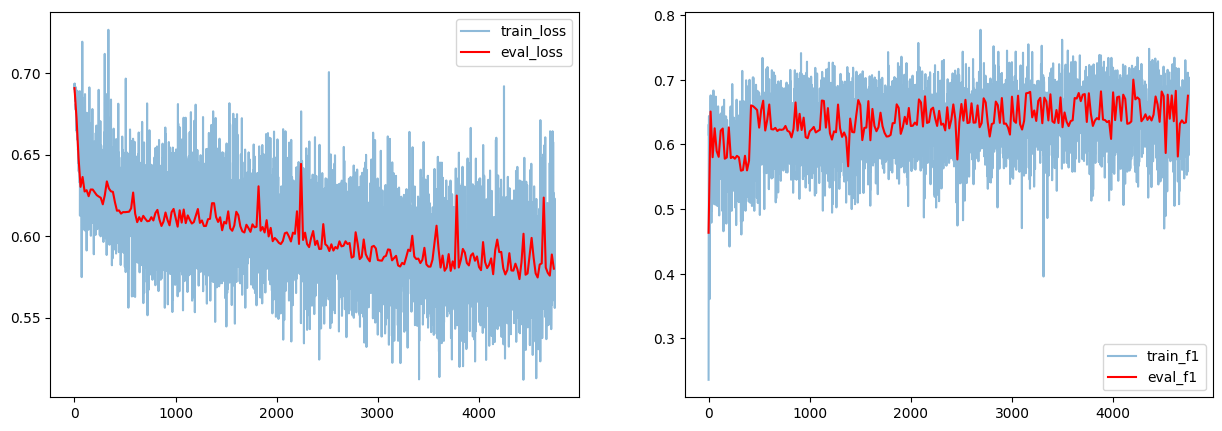

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.30it/s]


In [45]:
activation = nn.ReLU
hidden_sizes = [15, 15, 15]
model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [46]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.5791736021637917
Значение f1-score на валидационной выборке:  0.6366704161979753
Значение лосса на тестовой выборке:  0.5783241912722588
Значение f1-score на тестовой выборке:  0.6309037900874636


### Теперь попробуем гиперболический тангенс

Качество примерно на уровне relu

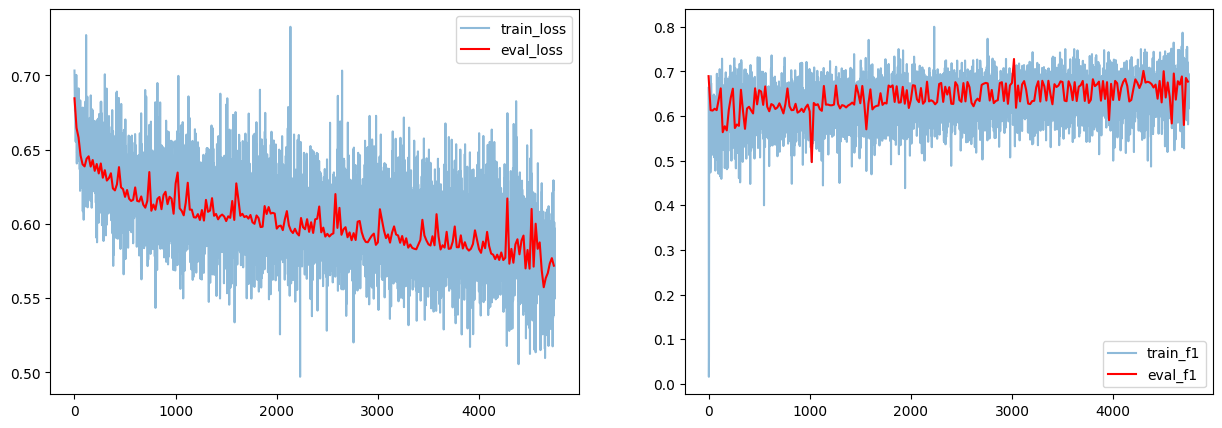

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.24it/s]


In [47]:
activation = nn.Tanh
hidden_sizes = [15, 15, 15]
model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [48]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.5751140713691711
Значение f1-score на валидационной выборке:  0.6424104604889141
Значение лосса на тестовой выборке:  0.5674502998590469
Значение f1-score на тестовой выборке:  0.6508595139300534


остановимся на слдующих параметрах:

activation = nn.Sigmoid

hidden_sizes = [15, 15, 15]

model = MLP(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)

model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=0.005)

model = train_model(model, optimizer=optimizer, num_epochs=200)


### Несмотря на то, что у нас неглубокая сети и не очень много данных, кроме того мы проводим нормализацию в самом начале (Standart Scaler), пробуем добавить batchnorm1d слой и посмотреть на показатели качества модели.

С добавлением батч нормализации происходит полный кошмар, лосс на трейне падает, но на валдиации растет.
Также модель становится крайне нестабильной, что мы можем видеть по высокому разбросу f1-score

In [49]:
class MLP_BN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation_fn):
        super(MLP_BN, self).__init__() 
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.BatchNorm1d(sizes[i+1]), activation_fn()])
            
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

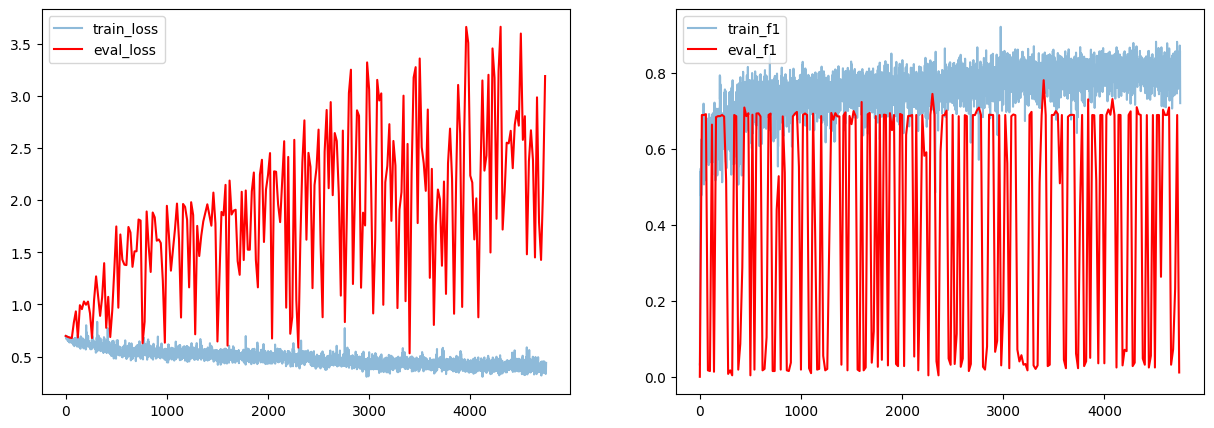

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.70it/s]


In [50]:
activation = nn.Sigmoid
hidden_sizes = [15, 15, 15]
model = MLP_BN(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [51]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  2.3983534276485443
Значение f1-score на валидационной выборке:  0.6893840104849279
Значение лосса на тестовой выборке:  2.5038856863975525
Значение f1-score на тестовой выборке:  0.6719787516600265


### Попробуем добавить dropout слои с разными параметрами и посмотрим на результаты

In [52]:
class MLP_DO25(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation_fn):
        super(MLP_DO25, self).__init__() 
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), activation_fn(), nn.Dropout(0.25)])
            
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

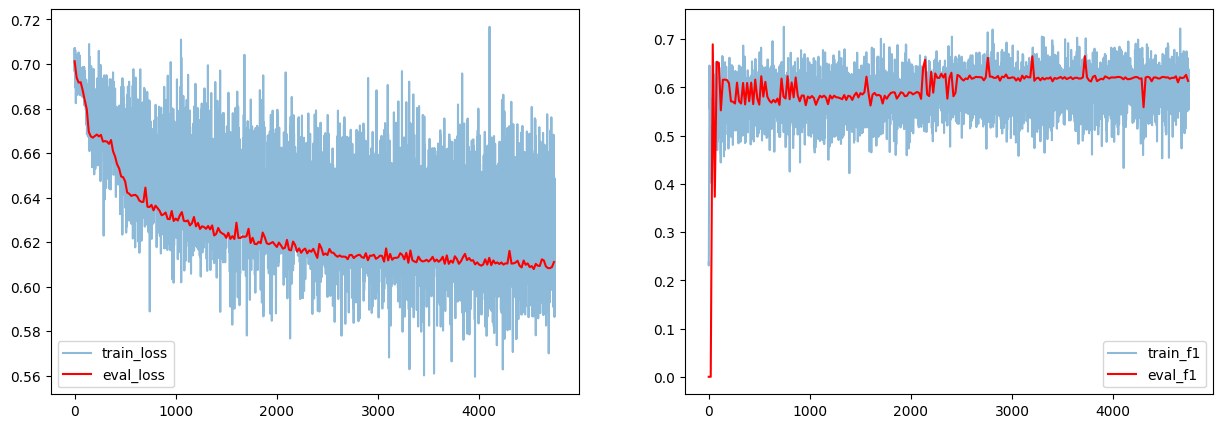

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:33<00:00,  6.04it/s]


In [53]:
activation = nn.Sigmoid
hidden_sizes = [15, 15, 15]
model = MLP_DO25(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [54]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.6085179671645164
Значение f1-score на валидационной выборке:  0.6184873949579832
Значение лосса на тестовой выборке:  0.6037641912698746
Значение f1-score на тестовой выборке:  0.617096018735363


In [55]:
class MLP_DO01(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation_fn):
        super(MLP_DO01, self).__init__() 
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), activation_fn(), nn.Dropout(0.01)])
            
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

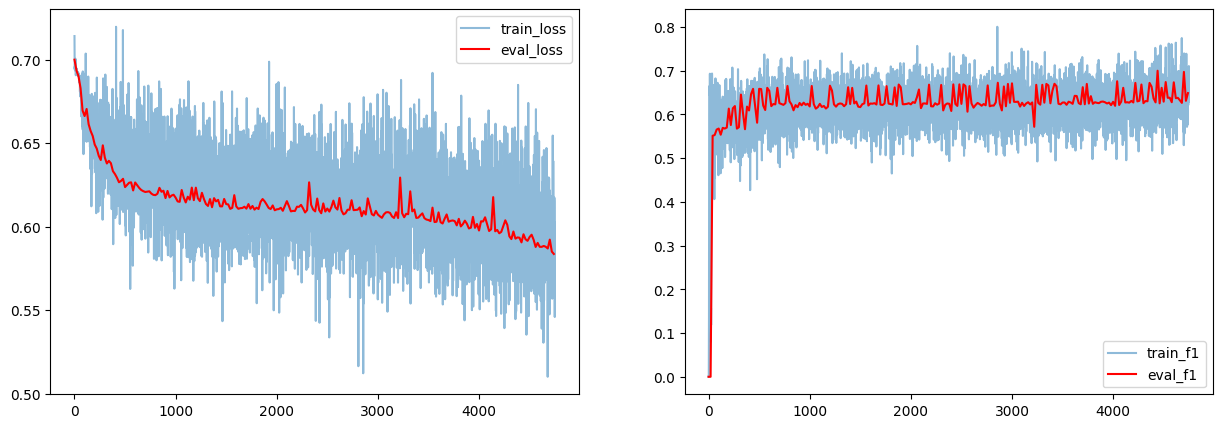

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:32<00:00,  6.09it/s]


In [56]:
activation = nn.Sigmoid
hidden_sizes = [15, 15, 15]
model = MLP_DO01(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [57]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.5859614014625549
Значение f1-score на валидационной выборке:  0.6338736724427054
Значение лосса на тестовой выборке:  0.5801263973116875
Значение f1-score на тестовой выборке:  0.6351829988193625


In [58]:
class MLP_DO50(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation_fn):
        super(MLP_DO50, self).__init__() 
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), activation_fn(), nn.Dropout(0.5)])
            
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

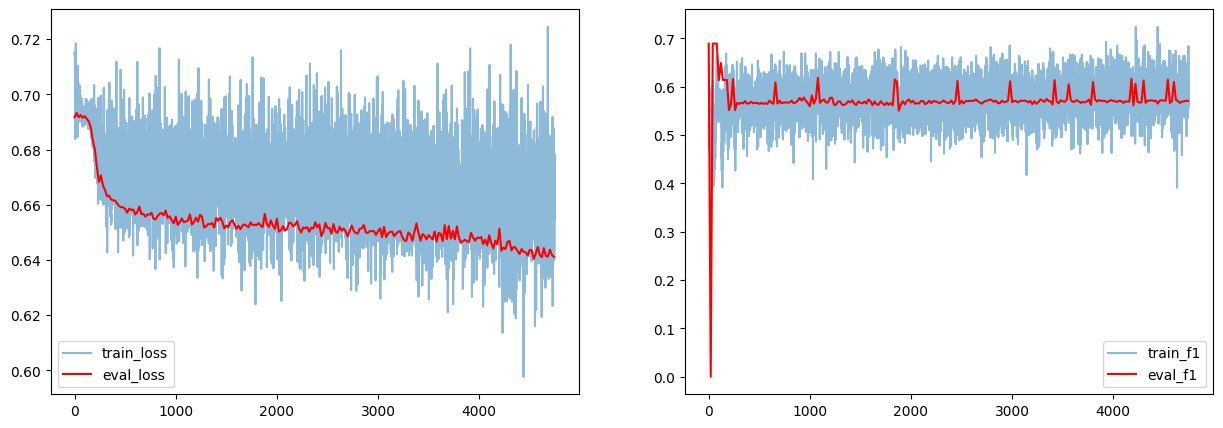

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:31<00:00,  6.28it/s]


In [59]:
activation = nn.Sigmoid
hidden_sizes = [15, 15, 15]
model = MLP_DO50(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [60]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.6413111910223961
Значение f1-score на валидационной выборке:  0.572599531615925
Значение лосса на тестовой выборке:  0.6402522101998329
Значение f1-score на тестовой выборке:  0.5748360166964818


Как мы можем видеть, при увелечении параметра p у нас падает качество, но при этом при маленьком значении оно не достигает максимума, поэтому выберем промежуточный вариант p=0.25

### Теперь скомбинируем dropout и batch norm слои

In [61]:
class MLP_BN_DO(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes, activation_fn):
        super(MLP_BN_DO, self).__init__() 
        layers = []
        sizes = [input_size] + hidden_sizes
        
        for i in range(len(sizes)-1):
            layers.extend([nn.Linear(sizes[i], sizes[i+1]), nn.BatchNorm1d(sizes[i+1]), activation_fn(), nn.Dropout(0.25)])
            
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return torch.sigmoid(self.layers(x))

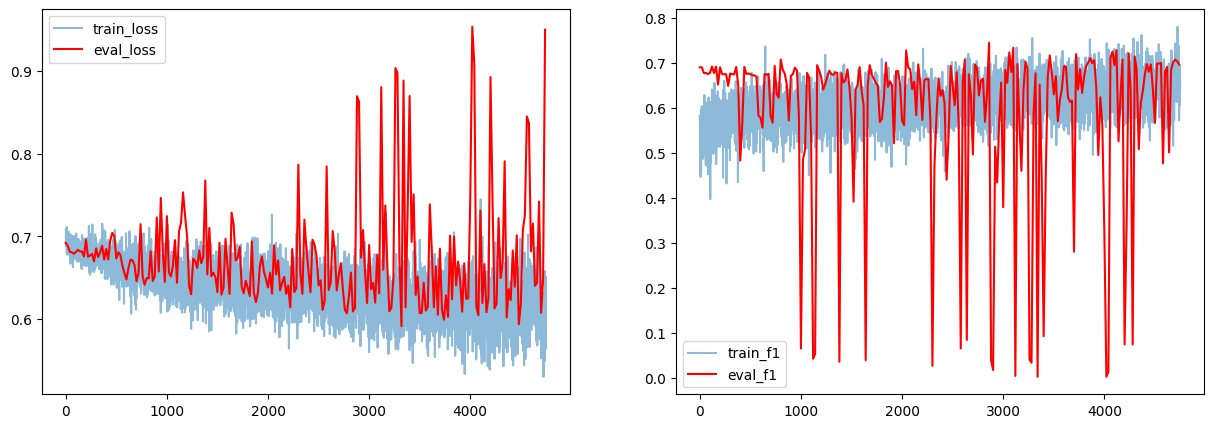

100%|████████████████████████████████████████████████████████████████████████████████| 200/200 [00:36<00:00,  5.53it/s]


In [62]:
activation = nn.Sigmoid
hidden_sizes = [15, 15, 15]
model = MLP_BN_DO(input_size=15, output_size=1, hidden_sizes=hidden_sizes, activation_fn=activation)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.005)
model = train_model(model, optimizer=optimizer, num_epochs=200)

In [63]:
print('Значение лосса на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[0])
print('Значение f1-score на валидационной выборке: ', eval_mod(model, loader=val_dataloader)[1])
print('Значение лосса на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[0])
print('Значение f1-score на тестовой выборке: ', eval_mod(model, loader=test_dataloader)[1])

Значение лосса на валидационной выборке:  0.5949752181768417
Значение f1-score на валидационной выборке:  0.6366594360086768
Значение лосса на тестовой выборке:  0.5813327133655548
Значение f1-score на тестовой выборке:  0.659477866061294


Модель показывает себя лучше, чем просто batch norm, но это далеко не стабильная модель в любом случае

### Выводы:

1.   Самый лучший результат показала модель с 4-мя линейными слоями, одинаковых размеров.
2.   Оптимизатор - AdamW.
3.   Функция активации - Сигмоида.
4.   Гиперпараметры модели: p = 0.25, lr = 0.005.

Так как у меня нет гпу, то я перебирал маленькое кол-во параметров.

При условии мощного компьютера имеет смысл запустить оптуну на кросс валдиации и подобрать наилучшие параметры.

Также разрабатывав и тестировав по ходу еще другие вариации параметров кроме представленных, пришел к выводу, что при всех выше зафиксированных сидах, все равно нет вопроизводимости ноутбука(
